In [ ]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import output

In [ ]:
!unzip roads.zip
output.clear()

In [ ]:
image_path = "roads/*"
images_array= []
for image in glob.glob(image_path):
  img= Image.open(image)
  img =Image.Image.resize(img, (240,240))
  img= np.asarray(img)
  images_array.append(img)

images_array=np.asarray(images_array)
x_train = images_array.astype('float32')
x_train = (x_train-127.5)/127.5

In [ ]:
#designing the archtecture of the generator and discriminiator

from keras.models import Model, Sequential
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
generator = Sequential(
    [
     Dense(128*60*60, input_dim=100, activation =LeakyReLU(0.2)),
    BatchNormalization(),
    Reshape((60,60,128)),
    UpSampling2D(),
    Convolution2D(128,5,5, border_mode="same", activation =LeakyReLU(0.2)) ,
    BatchNormalization(),
    Convolution2D(56,3,3, border_mode="same", activation=LeakyReLU()),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(3,5,5, border_mode="same", activation="tanh")
    ]
) 

generator.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), activation=<keras.lay..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(56, (3, 3), activation=<keras.lay..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), activation="tanh", padding="same")`
  if sys.path[0] == '':


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 460800)            46540800  
_________________________________________________________________
batch_normalization_5 (Batch (None, 460800)            1843200   
_________________________________________________________________
reshape_2 (Reshape)          (None, 60, 60, 128)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 120, 120, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 120, 120, 128)     409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 120, 120, 128)     512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 120, 120, 56)     

In [ ]:
discriminator= Sequential([
    Convolution2D(124,5,5, subsample=(2,2), input_shape=(240,240,3), border_mode="same", activation=LeakyReLU(0.4)),
    Dropout(0.4),
    Convolution2D(124,5,5, subsample=(2,2), border_mode="same", activation=LeakyReLU(0.4)),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 120, 120, 124)     9424      
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 120, 124)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 124)       384524    
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 60, 124)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 446400)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 446401    
Total params: 840,349
Trainable params: 840,349
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(124, (5, 5), input_shape=(240, 240,..., activation=<keras.lay..., strides=(2, 2), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(124, (5, 5), activation=<keras.lay..., strides=(2, 2), padding="same")`
  after removing the cwd from sys.path.


In [ ]:
#compiling the model

from tensorflow.keras.optimizers import Adam

adam= Adam(lr=0.001, beta_1=0.5)
discriminator.trainable= True
discriminator.compile(loss='binary_crossentropy' , optimizer=adam)


In [ ]:
generator.compile(loss='binary_crossentropy' , optimizer=adam)
ganInput= Input(shape=(100,))
x =  generator(ganInput)

discriminator.trainable= False
ganOutput = discriminator(x)

gan =Model(input= ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [ ]:
def train(num_epoch, batch_size):
  batch_count = x_train.shape[0] // batch_size  
  print("batch count: {}".format(batch_count))

  for epoch in range(num_epoch):
    print("Epoch number{}".format(epoch))
    
    for batch in range(batch_size):
        noise_input = np.random.rand(batch_size, 100)
        fake_images= generator.predict(noise_input, batch_size= batch_size)

        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        images = np.concatenate([fake_images, image_batch])

        labels= [0.95] *batch_size + [0.05] *batch_size

        discriminator.trainable =True
        d =  discriminator.fit(images, labels, verbose = 0)

        y_generator = [0.05]* batch_size
        discriminator.trainable = False
        g= gan.fit(noise_input, y_generator, verbose=0)
        input_g = np.random.rand(1, 100)
        preds= (generator.predict(input_g)+1.0)/2.0

        if epoch%10 == 0:
          for pred in range(preds.shape[0]):
            plt.imshow(preds[pred])
            if epoch%30 == 0:
              plt.savefig("GAN_output/epoch{}.jpg".format(str(epoch)), dpi= 250)
          plt.show()

In [ ]:
!mkdir GAN_output

mkdir: cannot create directory ‘GAN_output’: File exists


Epoch number599
Epoch number600


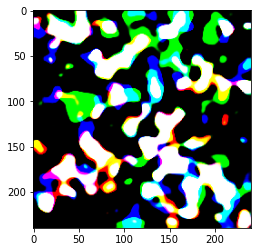

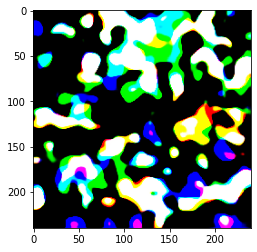

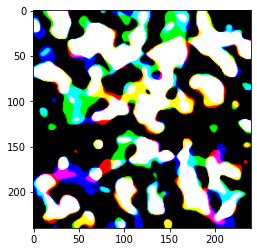

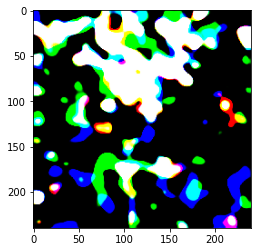

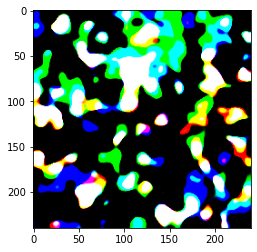

Epoch number601
Epoch number602


KeyboardInterrupt: ignored

In [ ]:
train(50000, 5)